### Non-Linear Models

- Change the following in the src/compBF.py file 

```
from src.modelpair2 import FirstModel, SecondModel
```

In [1]:
import torch
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy import integrate
from torch.distributions.multivariate_normal import MultivariateNormal

# our scripts and functions 
from src.compBF import BayesFactor
from src.compBF import repetitions, plot_evidence, plot_bf
from config import get_config

In [2]:
config = get_config('nonlinear')
labels = (r'$y=E + \textrm{sin}\,Ft$', r'$y=at^{2}+bt$')

# change the number of data if we want 
config.ndata = 100

# change the fiducial point if we want 
# config.fid1 = torch.Tensor([x0, x1])
# config.fid2 = torch.Tensor([y0, y1])

sigma = 1.0
noisecov = torch.eye(config.ndata) * sigma**2

# Testing Numerical Integration

In [3]:
module = BayesFactor(config, noisecov)

Model 1: E + sin(Ft)
Model 2: at^2 + bt


The data is being generated from Model 1 at the default fiducial point (same as in Alan's draft).

In [4]:
data = module.model1.fid_model + sigma * torch.randn(config.ndata)

In [5]:
def loglike1(parameters, module, data, noisecov):
    theory = module.model1.function(parameters = parameters, domain=module.domain)
    distribution = MultivariateNormal(theory, noisecov)
    return distribution.log_prob(data).item()

def logprior1(parameters, module):
    nparams = len(parameters)
    mean = torch.zeros(nparams)
    cov = torch.eye(nparams) * module.config.priorwidth**2
    distribution = MultivariateNormal(mean, cov)
    return distribution.log_prob(parameters).item()

def logpost1(parameters, module, data, noisecov):
    parameters = torch.from_numpy(parameters)
    loglike = loglike1(parameters, module, data, noisecov)
    logprior = logprior1(parameters, module)
    return loglike + logprior

def integration(param1, param2, module, data, noisecov, logpost_max):
    parameters = np.array([param1, param2])
    logpost = logpost1(parameters, module, data, noisecov) - logpost_max
    return np.exp(logpost)

nlp = lambda *args: -logpost1(*args)

### Optimisation
Just to check we have a sound estimate of the fiducial point.

In [7]:
solution = minimize(nlp, module.model1.fid_params, args=(module, data, noisecov))
covariance = solution.hess_inv
minimum = solution.x
logpost_max = logpost1(minimum, module, data, noisecov)
arguments = (module, data, noisecov, logpost_max)

2D integration using `scipy.integrate`.

In [8]:
# this cell is expensive because we are doing a 2D integration
value, error = integrate.dblquad(integration, -np.inf, np.inf, -np.inf, np.inf, args=arguments)

In [9]:
evi_numerical_1 = logpost_max + np.log(value)
evi1, evi2, bayesfactor = module.log_evi_full_data(data)

In [10]:
print(f'Exact function, Numerical integration    : {evi_numerical_1:.3f}')
print(f'Taylor expansion, Analytical integration : {evi1:.3f}')

Exact function, Numerical integration    : -137.524
Taylor expansion, Analytical integration : -138.167


In [11]:
print(f'BF: Exact function, Numerical integration    : {evi_numerical_1-evi2:.3f}')
print(f'BF: Taylor expansion, Analytical integration : {bayesfactor:.3f}')

BF: Exact function, Numerical integration    : 1.866
BF: Taylor expansion, Analytical integration : 1.222


### Single Example

In [3]:
# module = BayesFactor(config, noisecov)
# data = module.model1.fid_model + sigma * torch.randn(config.ndata)
# quant_full_data = module.log_evi_full_data(data)
# quant_comp_data = module.log_evi_comp_data(data)

### Repeated Data

In [4]:
df_nonlinear = repetitions(config, 5000, noisecov, sigma)

In [5]:
df_nonlinear.head()

,evi_full_1,evi_full_2,bf_full_12,evi_comp_1,evi_comp_2,bf_comp_12
0,-82.420279,-84.704454,2.284175,-19.265419,-21.546600,2.281181
1,-80.544730,-81.717172,1.172442,-20.558593,-21.734029,1.175437
2,-83.682457,-84.934056,1.251598,-19.557157,-20.800182,1.243024
3,-73.943274,-73.424951,-0.518323,-19.813707,-19.289717,-0.523990
4,-77.012398,-76.674773,-0.337625,-18.506041,-18.167783,-0.338258


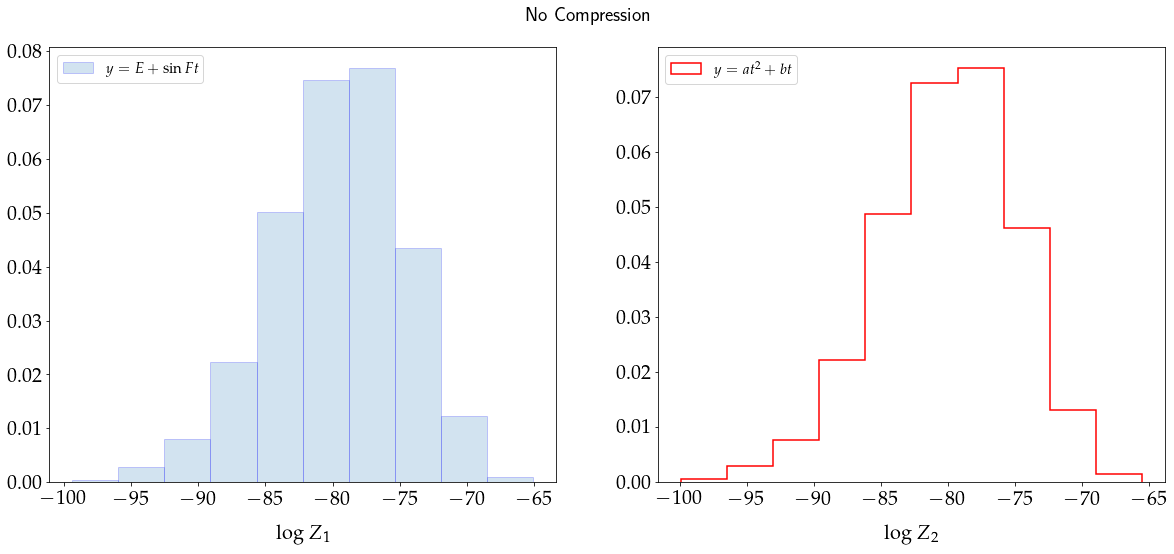

In [6]:
plot_evidence(df_nonlinear, compression=False, labels=labels, save=True, linear = False)

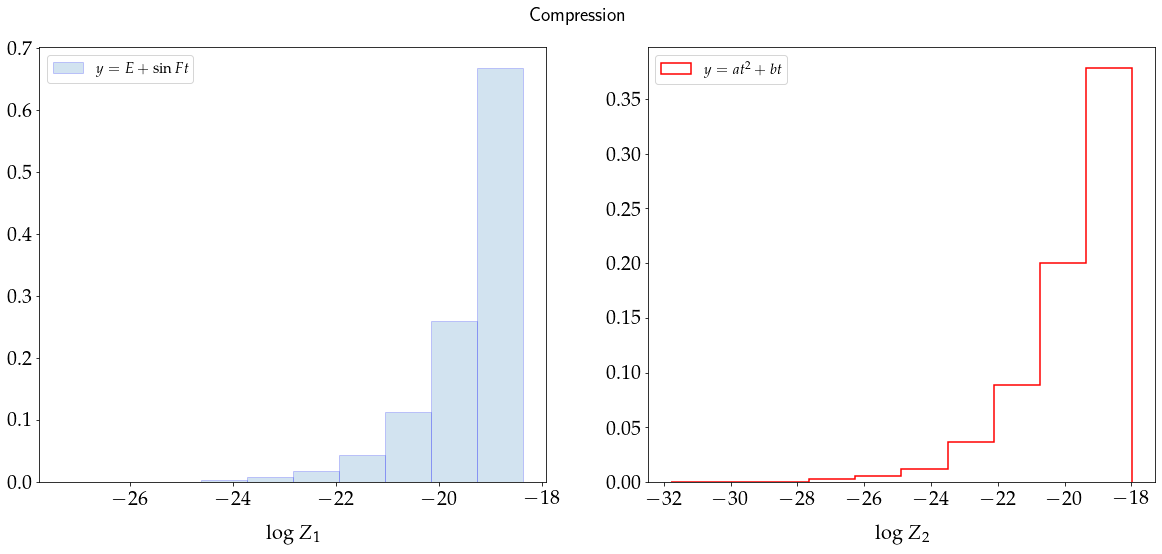

In [7]:
plot_evidence(df_nonlinear, compression=True, labels=labels, save=True, linear=False)

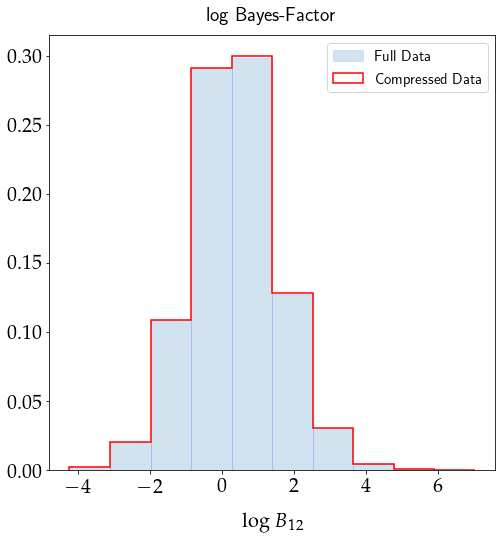

In [8]:
plot_bf(df_nonlinear, linear=False, save=True)